# 5MA Sujet de projet

# Transfert d'organe sous incertitude sur la compatibilité

Avant de commencer il faut placer le curseur du répertoire courant à la racine du projet. Cela sera nécessaire pour la suite.

In [3]:
using Random, MetaGraphs, SimpleWeightedGraphs, Graphs, JuMP, DelimitedFiles, Distributions, Plots, GraphPlot, HiGHS, DataFrames, Plots

while (last(split(pwd(), Base.Filesystem.path_separator)) != "KidneyExchangeProgram")
    cd("..")
end
println(pwd())

c:\Users\loicf\Documents\INSA\GM\5GM\OptimIncert\KidneyExchangeProgram


Nous importons ici les différents fichiers qui seront nécessaires au bon fonctionnement de ce projet.

In [4]:
# include files for the data reading and data extraction
include(join(["utils", "graph_extraction.jl"], Base.Filesystem.path_separator))
include(join(["utils", "data_reading.jl"], Base.Filesystem.path_separator))

# include files for the modeling and solving part

## stochastic optimization
include(join(["src", "stochastic_framework", "master_problem.jl"], Base.Filesystem.path_separator))
include(join(["src", "stochastic_framework", "recourse_problem.jl"], Base.Filesystem.path_separator))
include(join(["src", "stochastic_framework", "unroll_problem.jl"], Base.Filesystem.path_separator))
include(join(["src", "stochastic_framework", "solver.jl"], Base.Filesystem.path_separator))
include(join(["src", "stochastic_framework", "solution_evaluation.jl"], Base.Filesystem.path_separator))

## deterministic optimization
include(join(["src", "dtm_framework", "complete_recourse.jl"], Base.Filesystem.path_separator))

# for the random simulations
include(join(["utils", "monte_carlo.jl"], Base.Filesystem.path_separator))

# for displaying the solution
include(join(["utils", "visualization.jl"], Base.Filesystem.path_separator))
include(join(["utils", "sum_up.jl"], Base.Filesystem.path_separator))
include(join(["utils", "graph_modification.jl"], Base.Filesystem.path_separator))
    
# for solution extraction
include(join(["utils", "solution_extraction.jl"], Base.Filesystem.path_separator))

getClusterUsefull

## Introduction

Malgré l'augmentation croissante du nombre de transplantations d'organes effectuées chaque année (environ 6000 en 2017 dont 3782 transplantations de reins), la demande reste en perpétuelle augmentation. Ainsi 6000 organes, dont 3782 reins, ont été transplantés en 2017, mais il y avait encore 24000 personnes en attente d'un organe la même année. Les organes transplantés peuvent provenir d'un donneur décédé ou, dans le cas des reins et du foie, d'un donneur vivant consentant, le plus souvent membre de la famille du patient. Hélas, même si un proche accepte de prendre ce risque pour sa santé, il ne sera pas forcément compatible avec le patient. Pour cette raison, les pratiques médicales les législations évoluent dans de nombreux pays afin de permettre la mise en place d'un programme d'échange de dons d'organes.

L'exemple le plus simple d'échange de don d'organes est celui où deux patients $P_1$ et $P_2$ sont accompagnés de donneurs $D_1$ et $D_2$. Les patients sont supposés incompatibles avec les donneurs qui les accompagnent, mais on suppose que $D_1$ est compatible avec $P_2$ et $D_2$ avec $P_1$. Il est alors possible de transplanter un organe de $D_1$ vers $P_2$ et de $D_2$ vers $P_1$ avec le consentement de tous et en suivant la procédure légale.

Plus généralement, un cycle d'échange d'organes associe $k$ paires de patient-donneur $(P_{i_1},D_{i_1}), \dots, P_{i_k},D_{i_k})$ de sorte que $D_{i_l}$ donne à $P_{i_{l+1}}$ pour $l=1,\dots,k-1$ et $D_{i_k}$ donne à $P_{i_1}$.
Par ailleurs, le point essentiel est que les transferts soient tous réalisés en même temps et dans le même hôpital pour éviter qu'une rétractation de dernière minute ne lèse un patient et son donneur, et que les patients et donneurs venus ensemble et leur famille puissent se soutenir émotionnellement durant l'hospitalisation. 
Pour cette raison, le nombre d'échanges prenant place au sein d'un même cycle est nécessairement limité. En pratique, l'organisation d'un cycle de trois paires est déjà une épreuve pour le personnel d'un hôpital, et le plus grand cycle ayant jamais eu lieu a a impliqué six patients et donneurs.

Dans ce projet, nous prendrons le point de vue de l'organisme national responsable de la gestion du programme d'échange d'organes. 
À chaque phase d'échange, l'objectif de cet organisme est de choisir un ensemble de cycles d'échanges entre paires compatibles afin de maximiser le nombre de patients recevant un organe. Dans certains cas, on peut aussi donner une priorité à certains patients en fonction de la gravité de leur état ou de la durée de leur attente. 
Pour cela, on pourra attribuer des poids différents à chaque patient et maximiser la somme des poids des patients recevant un organe. 

Lors d'une première phase de planification, l'organisme ne dispose que de données individuelles sur chaque donneur et chaque receveur pour déduire la compatibilité entre donneurs et patients. 
Ces données sont principalement le groupe sanguin et le complexe majeur d’histocompatibilité, aussi appelé système HLA. 
Ils en tirent un premier graphe de compatibilité orienté, $G=(V,A)$, où chaque sommet de $V$ représente une paire donneur-patient et où un arc entre deux paires $(P_k,D_k)$ et $(P_l,D_l)$ signifie que $D_k$ est __a priori__ compatible avec $P_l$.
Cependant, la compatibilité effective entre deux personnes ne peut être assurée qu'en mettant en présence des tissus des deux personnes dans ce que l'on appelle un _test croisé_. 
En général, on peut supposer que les données individuelles permettent de déterminer une probabilité de réussite du test croisé.
Mais, dans tous les cas, ces tests peuvent être lourds à réaliser pour les patients et demander des ressources importantes aupèrs des services hospitaliers, donc leur nombre sera toujours limité. 
On pourra pour cela considérer une limite fixe, une limite dépendant du nombre de paires patient-donneur ou bien supposer que les tests ne servent qu'à confirmer la compatibilité après avoir décidé les cycles d'échange entre patients a priori compatibles. 


---

Ici on distingue bien un problème de type optimisation sous incertitude. On une décision à priori qui est les cycles que nous choisissons et ensuite nous réalisons des tests. Ces différents tests nous permettront de nous assurer à postériori des différentes compatibilités réelles.

TODO : définir les variables à priori et les variables de recours $x$ seront les variables à priori et $y$ seront les variables de recours


- une première contrainte apparaît ici : on ne veut limiter la longueure des cycles. Si on considère des cycles qui sont trop longs on va avoir des problèmes dans notre mise en place à l'hopital.

- il y aura ensuite tout un ensemble de contraintes qui nous permettront de définir ce que l'on appel des cycles.

## Description des données

Des jeux de données correspondant à des ensembles de paires patient-donneur ont été partagés dans la PrefLib (https://www.preflib.org/data/MD). Le sous-ensemble d'instances auxquels vous pourrez vous intéresser dans un premier temps accompagne ce sujet sur Moodle. Les dix premières instances (numérotées de 1 à 10) contiennent 10 paires patient-donneur, les 10 suivantes (numérotées de 31 à 40) en contiennent 32 et les 10 dernières (numérotées de 71 à 80) en contiennent 64. Chaque jeu de données est décrit par deux fichiers, l'un énumérant les données relatives à chaque paire et portant l'extension .dat, et l'autre énumérant les données relatives aux arcs et portant l'extension .wmd.
Nous vous fournissons une fonction permettant de lire les fichiers relatifs à un jeu de donnéees. 

Une fois le graphe de compatibilité donné, une instance est entièrement décrite par la connaissance de la distribution des incertitudes dans une approche par optimisation stochastique. Dans une approche par optimisation robuste, le pire cas est déjà connu pour chaque arête, il s'agit d'un échec de la transplantation. Plusieurs modèles d'incertitudes sont classiquement regardés dans la littérature, mais tous considèrent que la réussite du test croisé réalisé sur un arc $a$ suit une loi de Bernouilli de probabilité $1-f_a$ où $f_a$ est une probabilité d'échec donnée. Nous donnons ci-dessous la fonction permettant de calculer des probabilités d'échec pour tous les arcs en fonction d'un paramètre à choisir dans le tableau DISTRIBUTIONS.

---

Sur chaque arrète on va avoir la probabilité que le transplantation soit réussit ou pas.

In [12]:
j = 1
list_dir = readdir(join(["_cache", "data"], Base.Filesystem.path_separator));
myregex = r"MD-00001-0+(\d+).dat"
list_name = Int[]
list_n_nodes = Int[]
list_n_edges = Int[]
list_n_circles = Int[]
list_n_nodes_preprocess = Int[]
list_n_edges_preprocess = Int[]

for i in 1:1:(length(list_dir)/2)
    try
        kep_graph = read_kep_file("./_cache/data/"*list_dir[j+1],"./_cache/data/"*list_dir[j]);
        append!(list_name, parse(Int64, match(myregex, list_dir[j])[1]))
        append!(list_n_edges, ne(kep_graph))
        append!(list_n_nodes, nv(kep_graph))
        append!(list_n_circles, length(simplecycles_limited_length(kep_graph, 4, 10^6)))
        # preprocessing 
        kep_graph = removetUselessNodes(kep_graph, 4)
        append!(list_n_edges_preprocess, ne(kep_graph))
        append!(list_n_nodes_preprocess, nv(kep_graph))
        j += 2
    catch
        println("error in reading")
        j = j+1
    end
end

print(DataFrame(name = list_name, 
n_edge=list_n_edges, 
n_node=list_n_nodes, 
n_circle=list_n_circles, 
n_edge_preprocess=list_n_edges_preprocess, 
n_node_preprocess=list_n_nodes_preprocess))

error in reading
28×6 DataFrame
 Row │ name   n_edge  n_node  n_circle  n_edge_preprocess  n_node_preprocess 
     │ Int64  Int64   Int64   Int64     Int64              Int64             
─────┼───────────────────────────────────────────────────────────────────────
   1 │     1      59      16         3                  6                  4
   2 │     2      65      16        21                 38                 10
   3 │     3      50      16         3                  6                  4
   4 │     4      26      16         0                  0                  0
   5 │     5      70      16        36                 44                 13
   6 │     6      28      16         4                  8                  5
   7 │     7      48      16         8                 11                  5
   8 │     8      48      16        38                 40                 12
   9 │     9      59      16        33                 40                 11
  10 │    10      47      16        15   

## Travail à réaliser

Nous vous donnons une grande liberté sur la façon de traiter le sujet. En fonction de décisions que vous justifierez, vous pourrez traiter le problème par une approche d'optimisation stochastique, d'optimisation robuste ou de toute autre approche averse aux risques. Le travail commencera par décrire l'approche suivie puis le modèle en découlant. Un code Julia permettra ensuite d'implémenter une ou plusieurs méthodes de résolution pour le modèle. Vous pourrez tester la ou les méthodes sur des instances de la PrefLib. Vos interprétations devront rendre compte des enjeux pratiques et des enjeux algorithmiques (optimalité, temps de calcul, passage à l'échelle, etc.) de votre travail.
Le résultat de votre travail sera à rendre dans ce notebook avant le 14 janvier 2022. Chaque cellule du notebook aura préalablement été exécutée (sans erreur, évidemment), et il importera que les affichages utilisés dans vos interprétations y apparaissent. 

## Les données

Nous allons travailler ici avec des données sous forme de graphes. Les fonctions `read_kep_file` et `get_failure_rates` du fichier `.\utils\data_reading.jl` nous permettent de lire les fichier de données correspondant au problème de construire le graphe correspondant et ensuite de venir calculer les probabilités d'échec (du test croisé) de chaque arc. Voici un exemple d'utilisation des deux premières fonctions :

In [4]:
kep_graph = read_kep_file("./_cache/data/MD-00001-00000080.wmd","./_cache/data/MD-00001-00000080.dat");
failure_rates = get_failure_rates(kep_graph, "Constant");

La fonction `extractCycleInformation` du fichier `.\utils\graph_extraction.jl`, nous permettra de venir extraire des données du graph crée. Cette fonction est orienté sur les cycles.

In [5]:
print(@doc(extractCycleInformation))

```
extractCycleInformation
```

This function allow us to extract the relevant information from the kep*graph. The relevant information here concern the cycle formulation of the kep*graph.

# Parameters

  * `g` : the kep_graph
  * `K` (int): the length of the Cycles
  * `mode`: the method to use to compute the calculus of the utilities

# Return

This function returns a Julia dictionnary with the following keys :

  * `Cycles_index` : a list of integer each element of the list corresponds to the index of a cycle
  * `vertic_cycles` : a dictionnary with vertices as keys and a list of cycles which involve the key as value
  * `Cycles` : the exhaustive enumeration of the cycles
  * `P` : for each cycle, the probability of failure. To get the success do 1 - ...
  * `U` : the utility of each cycle


In [6]:
extract_data = extractCycleInformation(kep_graph, 3, "sum");

## Un problème (presque) à recours

Notre première vision de ce problème était de réfléchir uniquement sur les cycles. Nous adoptons la philosophie qui consiste à dire que on sélectionne des cycles et nous ne réalisons les tests croisés que parmis les cycles que nous avons sélectionnés

On définit ainsi les données suivantes :

- $C$ : l'ensemble des cycles de longueurs au plus $K$
- $\forall c \in C \quad w_c$ : désignera l'utilité du cycle $c$
- $\forall ~c~\in C\quad \xi_c(\omega) \in \{0, 1\} = 1$ : si et seulement si on ne peut pas sélectionner le cycle $c$ (les tests sont mauvais) pour la réalisation $\omega$

On définit les variables suivantes

- $1^{er}$ niveau : $\forall c \in C\quad x_c \in \{0, 1\} = 1$ si et seulement si, on décide de sélectionner le cycle $c$.
- recours : $\forall c \in C\quad y_c \in \{0, 1\} = 1$ on ne peut pas sélectionner le cycle $c$ suite à la réalisation des tests.

$$
\begin{equation}
	(\mathbb{CRP}) := \left\{\begin{aligned}
        \underset{x}{\min} \quad & - \sum_{c \in C} x_cw_c +\mathbb{E}\left(\underset{y}{\min} \left[\sum_{c \in C} y_cw_c\right]\right)\\
         s.c \quad &\sum_{c\in C_i}x_c\leq 1~\forall i \in V\\ % contrainte déterministe
         % les contraintes stochastiques
         & y_c = \xi_c(\omega)~x_c\quad \forall c \in C \quad \forall \omega \in \Omega\\ 
         & x_c \in \{0,1\} \quad \forall c \in C\\
         & y_c \in \{0,1\} \quad \forall c \in C
	\end{aligned}\right.
\end{equation}
$$

Nous pouvons ainsi reformuler ce problème de la façon suivante :

$$
\begin{equation}
	(\mathbb{CRP}) := \left\{\begin{aligned}
        \underset{x}{\min} \quad & - \sum_{c \in C} x_cw_c +\mathbb{E}\left( \left[\sum_{c \in C} \xi_cx_cw_c\right]\right)\\
         s.c \quad &\sum_{c\in C_i}x_c\leq 1~\forall i \in V\\ % contrainte déterministe
         & x_c \in \{0,1\} \quad \forall c \in C\\
	\end{aligned}\right.
\end{equation}
$$

Nous obtenons finalement :

$$
\begin{equation}
	(\mathbb{CRP}) := \left\{\begin{aligned}
        \underset{x}{\min} \quad & \sum_{c \in C} x_cw_c(\mathbb{E} \left[ \xi_c\right] - 1)\\
         s.c \quad &\sum_{c\in C_i}x_c\leq 1~\forall i \in V\\ % contrainte déterministe
         & x_c \in \{0,1\} \quad \forall c \in C\\
	\end{aligned}\right.
\end{equation}
$$

Avec $\mathbb{E}[\xi_c] = \mathbb{P}\{\xi_c = 1\}$ d'où $\mathbb{E}[\xi_c] - 1 = -\mathbb{P}\{\xi_c = 0\}$


Ainsi nous avons :

$$
\begin{equation}
	(\mathbb{CRP}) := \left\{\begin{aligned}
        \underset{x}{\max} \quad & \sum_{c \in C} x_cw_c(\mathbb{P}\{\xi_c = 0\})\\
         s.c \quad &\sum_{c\in C_i}x_c\leq 1~\forall i \in V\\ % contrainte déterministe
         & x_c \in \{0,1\} \quad \forall c \in C\\
	\end{aligned}\right.
\end{equation}
$$


Ainsi nous pourrons note $\tilde{w}_c = w_c \times \mathbb{P}\{\xi_c = 0\}$, la nouvelle utilité d'un cycle qui sera en faite une combinaison entre l'utilité réelle du cyle $w_c$ et la probabilité que ce dernier se réalise. Nous pouvons ici que un cycle avec $w_c$ grand mais une probabilité de succés très faible aura peu de chance d'être choisi. En effet pourquoi choisir ce cycle si on sait qu'il n'a aucune chance (ou presque) de se réaliser.

Nous avons finalement le problème suivante :

$$
\begin{equation}
	(\mathbb{CRP}) := \left\{\begin{aligned}
        \underset{x}{\max} \quad & \sum_{c \in C} x_c\hat{w}_c\\
         s.c \quad &\sum_{c\in C_i}x_c\leq 1~\forall i \in V\\ % contrainte déterministe
         & x_c \in \{0,1\} \quad \forall c \in C\\
	\end{aligned}\right.
\end{equation}
$$

Nous pouvons voir ainsi que ce problème $\mathbb{CRP}$ est donc un problème totalement déterministe. Nous proposons la méthode `completRecourseProblem` dans le fichier `dtm_framework/complete_recourse.jl`. Pour résoudre ce dernier. Cette dernière fonction possède la signature suivante :

In [7]:
print(@doc(completRecourseProblem))

```
completRecourseProblem
```

This is the deterministic version of the problem with the complete recourse.

# Parameters

  * `C` : index of the cycles
  * `vertic_cycles` : a dictionnary, at the key i of this list, give the a list of the index of the cycles which involve the node i
  * `U` : the utilities of each cycle in the graph.
  * `S_P` : probability of sucess of each cycle


In [8]:
# the data
kep_graph = read_kep_file("./_cache/data/MD-00001-00000080.wmd","./_cache/data/MD-00001-00000080.dat");
failure_rates = get_failure_rates(kep_graph, "Constant");
data = extractCycleInformation(kep_graph, 3, "sum");

# the model
res = completRecourseProblem(data["Cycles_index"], data["vertic_cycles"], data["U"], 1 .-data["P"]);
model = res["model"]

optimize!(model)

solution = value.(model[:x])
;

## La méthode des *clusters*

Les différents hopitaux nous ont contactés et nous ont expliqués que ce n'était pas à nous de dicter les tests à faire entre les différents patients. Ceci relève du domaine médicale et des infrastructure présentes dans chaque hopitaux. Il est attendu de nous de regrouper les pairs donneur receveur sous la forme de groupes pertinents. Les groupes formés alors seront pris en charge par un hôpital et au sein d'un groupe de personne toutes les différentes batteries de tests vont avoir lieu et permettront de déterminer les échanges à réaliser. Pour des raisons logistiques les hopitaux souhaitent aussi ne prendre en charge que des groupes de tailles raisonables. On notera dans la suite par la constante, $U$ la taille maximale des groupes autorisés. En effet sans une telle contrainte, nous pourrions mettre tous les patients dans le même groupe, réaliser tous les tests possibles et ensuite réaliser les échanges (Impossible !).

Notre objectif est alors le suivant, former des groupes (*cluster*) de personnes qui seront ensuites pris en charges par les hopitaux. Les clusters formés comme indiqués doivent être pertinents. Ils doivent permettre en moyenne de maximiser l'utilité des échanges que l'on génère.

Nous pouvons modéliser tout ceci de manière plus formelle sous la forme d'un problème d'optimisation stochastique avec recours. Nous noterons tout d'abord $C_K$ l'ensemble des cycles, du graph d'échange, de longueure $K$ ou moins. L'ensemble des scénarios possibles pour les différents tests croisés sera noté $\Omega$ et on notera $\omega$ une réalisation de l'ensemble des tests croisés. A noter que un scénario $\omega$ ne correpond pas à la réalisation de un test croisé, mais bien de l'ensemble des tests croisés dans le graphe d'échange.

Nous considérerons les variables :

- 1er niveau : $\forall (i,j) \in V\times V\quad x_{i,j} \in \{0,1\} = 1$ ssi $i$ et $j$ sont dans le même groupe.
- recours : $\forall c \in C_K \quad y_c(\omega) \in \{0,1\}=1$ ssi on décide de choisir le cycle $c$ pour réaliser les échanges dans le scénario $\omega$.

Nous définission le *cluster problem* de la manière suivante :

$$
\begin{equation}
	\mathbb{CP}:= \left\{\begin{aligned}
        \underset{y}{\max} &\quad \mathbb{E}_{\omega}\left[y_c(\omega) w_c\right]\\
         s.c &\quad x_{i,j} = x_{j,i}\quad \forall (i,j) \in V\times V\\
         &\quad x_{i,j} + x_{j,k} -1 \leq x_{i,k} \quad \forall (i,j,k) \in V\times V\times V\\
         &\quad \sum_{j \in V} x_{i,j} \leq U \quad \forall i \in V \\
         &\quad y_c(\omega) \leq x_{i,j}\xi_{i,j}(\omega) \quad \forall c \in C_k, ~\forall (i,j) \in c,~ \forall \omega \in \Omega \\
         &\quad \sum_{c \in C_K(i)} y_c(\omega) \leq 1 \quad \forall i \in V,\quad\forall \omega \in \Omega\\
	\end{aligned}\right.
\end{equation}
$$

Nous pouvons faire plusieurs remarques sur ce problème :

- Tout d'abord, nous pouvons voir que la variable de premier recours nous donne certes la formation des clusters, mais la variables de recours correspond pour chaque scénario $\omega$ à la variable de décision du problème déterministe vu dans les sections précédentes.

- Ce problème est un problème qui est à recours relatif complet. En effet nous pouvons voir que peut importe la valeur de $x$ que l'on prend nous pourrons choisir une valeur de $y$ pour chaque scénério qui sera réalisable. Pour vérifier ceci il suffit de se placer au pire cas qui est lorsque $x$ vaut $0$ (*i.e.* on ne forme aucun cluster), dans ce cas, prendre $y=0$ permet de respecter les contraintes. Cette propriété jouera un rôle intéressant, particulièrement lors du passage au dual sur la problème de recours (cf sections suivante).

### Méthode en L : Coupes de Benders
Dans le problème présentée précédemment nous avons finalement le problème de recours $v_{\omega}(x)$ (pour une réalisation $\omega$ des incertitudes) qui peut se présenter sous la forme suivante :

$$
\begin{equation}
	v_{\omega}(x):= \left\{\begin{aligned}
        \underset{y}{\max} \quad & \sum_{c \in C_{K}}y_c w_c\\
         s.c \quad & y_c \leq x_{i,j} \xi_{i,j}(\omega) \quad \forall (i,j) \in c ~,~\forall c \in C_K \\
         & \sum_{c \in C_i} y_c \leq 1 \quad \forall i \in V \\
         & y_c \leq 1 \quad \forall c \in C_K
	\end{aligned}\right.
\end{equation}
$$

Nous pouvons proposer un dual pour ce problème :

$$
\begin{equation}
	d_{\omega}(x):= \left\{\begin{aligned}
        \underset{y}{\min} \quad & \sum_{c \in C_{K}}\sum_{(i,j) \in c} \lambda_{(i,j)}^c x_{i,j}\xi_{i,j}(\omega) + \sum_{i \in V}\mu_i + \sum_{c \in C_K} \Delta_c\\
         s.c \quad & \sum_{i \in c} \mu_i + \Delta_c + \sum_{(i,j) \in c} \lambda_{(i,j)}^c\geq w_c \quad \forall c \in C_K \\
	\end{aligned}\right.
\end{equation}
$$

Nous pouvons faire une remarque intéressante ici. Le polyhèdre $P$ définit par :

$$
P := \{\lambda, \mu, \Delta \quad |\quad \sum_{i \in c} \mu_i + \Delta_c + \sum_{(i,j) \in c} \lambda_{(i,j)}^c\geq w_c \quad \forall c \in C_K\}
$$

Ne dépend pas de la réalisation $\omega$ des incertitudes. Nous noterons, par la suite, $\Lambda(P)$ les points extrèmes de ce polyhèdre. A noter que ici notre problème

Par dualité forte nous avons :

$$
\begin{equation}
	v_{\omega}(x)= d_{\omega}(x)= \left\{\begin{aligned}
        \underset{y}{\min} \quad & \sum_{c \in C_{K}}\sum_{(i,j) \in c} \lambda_{(i,j)}^c x_{i,j}\xi_{i,j}(\omega) + \sum_{i \in V}\mu_i + \sum_{c \in C_K} \Delta_c\\
         s.c \quad & \lambda, \mu, \Delta ~\in~\Lambda(P)\\
	\end{aligned}\right.
\end{equation}
$$

Ainsi nous avons :

$$
\begin{equation}
	v_{\omega}(x):= \left\{\begin{aligned}
        \underset{y}{\max} \quad & \theta \\
         s.c \quad & \theta \leq \sum_{c \in C_{K}}\sum_{(i,j) \in c} \lambda_{(i,j)}^c x_{i,j}\xi_{i,j}(\omega) + \sum_{i \in V}\mu_i + \sum_{c \in C_K} \Delta_c \quad\forall~\lambda, \mu, \Delta ~\in~\Lambda(P)\\
	\end{aligned}\right.
\end{equation}
$$

Nous pouvons finalement réecrir notre problème principal, de la manière suivante :

$$
\begin{equation}
	\mathbb{CP}:= \left\{\begin{aligned}
        \underset{x}{\max} \quad & \mathbb{E}_{\omega}[\theta(\omega)] \\
         s.c &\quad \theta(\omega) \leq \sum_{c \in C_{K}}\sum_{(i,j) \in c} \lambda_{(i,j)}^c x_{i,j}\xi_{i,j}(\omega) + \sum_{i \in V}\mu_i + \sum_{c \in C_K} \Delta_c \quad\forall~\lambda, \mu, \Delta ~\in~\Lambda(P)\quad \forall \omega \in \Omega\\
         &\quad x_{i,j} = x_{j,i}\quad \forall (i,j) \in V\times V\\
         &\quad x_{i,j} + x_{j,k} -1 \leq x_{i,k} \quad \forall (i,j,k) \in V\times V\times V\\
         &\quad \sum_{j \in V} x_{i,j} \leq U \quad \forall i \in V \\
	\end{aligned}\right.
\end{equation}
$$

<ins>La méthode de Benders</ins> :

La méthode en L (ou méthode de Benders) consistera à ne pas considérer l'ensemble $\Lambda(P)$ car combinatoire, mais considérer l'ensemble $\tilde{\Lambda}(P) \subset \Lambda(P)$. Nous résolvons la régularisation suivante :

$$
\begin{equation}
	\tilde{\mathbb{CP}}:= \left\{\begin{aligned}
        \underset{x}{\max} \quad & \mathbb{E}_{\omega}[\theta(\omega)] \\
         s.c &\quad \theta(\omega) \leq \sum_{c \in C_{K}}\sum_{(i,j) \in c} \lambda_{(i,j)}^c x_{i,j}\xi_{i,j}(\omega) + \sum_{i \in V}\mu_i + \sum_{c \in C_K} \Delta_c \quad\forall~\lambda, \mu, \Delta ~\in~\tilde{\Lambda}(P)\quad \forall \omega \in \Omega\\
         &\quad x_{i,j} = x_{j,i}\quad \forall (i,j) \in V\times V\\
         &\quad x_{i,j} + x_{j,k} -1 \leq x_{i,k} \quad \forall (i,j,k) \in V\times V\times V\\
         &\quad \sum_{j \in V} x_{i,j} \leq U \quad \forall i \in V \\
	\end{aligned}\right.
\end{equation}
$$

La résolution de ce problème nous donne une valeur de $x$ (solution de premier niveau) ainsi que de $\theta$. Ainsi pour cette valeur de $x$ donnée ainsi que pour l'ensemble de nos scénarios $\omega$ nous résolvons les différents problèmes $d_{\omega}(x)$. La résolution de ces différents problèmes pour chaque scénarios nous donne de nouveaux points extrèmes $(\lambda(\omega), \mu(\omega), \Delta(w))$ du polyhèdre $\Lambda(P)$. 

La question étant : est-il judicieux d'ajouter ces points extrèmes à notre sous ensemble ? En effet, ajouter des points extrèmes fait grossir notre problème et le rend par conséquent plus lent pour la résolution. Nous donnons ici un test nous permettant de répondre à cette question

Pour chaque scénario $\omega$ nous disposons de la variable $\theta(\omega)$ (suite à la première résolution), ainsi nous vérifions :

$$
\theta(\omega) \leq \sum_{c \in C_{K}}\sum_{(i,j) \in c} \lambda_{(i,j)}^c(\omega) x_{i,j}\xi_{i,j}(\omega) + \sum_{i \in V}\mu_i(\omega) + \sum_{c \in C_K} \Delta_c(\omega) + \epsilon
$$

Où $\epsilon > 0$ est une tolérance choisi arbitrairement petite. Si cette condition est vérifié, le point extrème trouvé n'est pas utile, sinon nous le rajoutons à notre ensemble (cela fait une contrainte ajoutée à notre problème initial), puis nous reprenons depuis le début.

Si a une itération, pour tous les scénarios $\omega$ tous les points extrèmes ajoutés ne sont pas judicieux à ajouter alors nous arrétons.

Nous proposons ici la méthode `LshapeClusterMethod` qui nous permet de fournir la méthode Benders pour notre problème avec les *clusters*. Le prototype de la fonction est donné dans la cellule suivante.

In [5]:
print(@doc(LshapeClusterMethod))

```
LshapeClusterMethod
```

This method propose the Benders method for the clustering problem. This method uses functions available in the files :

  * recourse_problem.jl
  * master_problem.jl

# Parameters

  * `kep_graph` : the graph of the kidney exchange program
  * `ClusterSize` : the size of the clusters
  * `C` : the list of the cycle index
  * `cycles` : the list of the real cycles
  * `U` : the list of the utilities
  * `vertic_cycles` : a Julia dictionnary. for each key the value is a list corresponding to the cycles involving the key
  * `ksi` : the tensor of the scenarios
  * `itmax` : the number of maximum iteration
  * `verbose` : if true, the main steps will be printed on the standard output.
  * `cvar`:

# Returns

This method returns a dictionnary with the following keys :

  * `first_level_var` : the value of x i.e. the first level solution.
  * `objective_value` : the objective value.
  * `nb_added_constraints` : the number of constraints we added through the itera

### Premiers tests sur la méthode en L

Nous allons venir tester cette méthode sur plusieurs exemples simples (pour la rapidité des calculs). Pour tester nos méthodes nous allons comparer la solution obtenu par l'algorithme de Benders et la solution du problème déroulé *i.e.* la solution du problème où on écrit toutes les contraintes pour chaque scénarios. On écrit comme un programme linéaire le problème $\mathbb{CP}$. Cette dernière méthode donne la solution théorique que l'on doit trouver. L'algorithme de Benders doit-il trouver cette solution là. Non pas forcément, la méthode de Benders utilise une relaxation linéaire (on considère les variables de recours comme continues et non plus binaires) lors de la résolution des problèmes de recours, de manière à en fournir un dual, qui sera ensuite ajouté à notre problème principal. Nous savons cependant que comme la méthode de Benders résoud une relaxation linéaire la solution qu'elle fournit doit-être au moins supérieur ou égale à la solution du problème déroulé.

Pour les différentes résolutions, nous utiliserons les paramètres suivant :
- $3$ comme taille maximum de cycles
- $10$ comme taille de cluster
- $100$ scénarios
- les probabilités associées à chaque arc seront égales.


In [6]:
df = DataFrame(
    Benders_status = Bool[], 
    nb_benders_iterations = Int[] , 
    nb_added_constraints = Int[], 
    objective_benders = Float64[], 
    unroll_objective = Float64[],
    number_of_cycles = Int[]
)

for k in 1:1:9
    try
        kep_graph = read_kep_file("./_cache/data/MD-00001-0000000$k.wmd","./_cache/data/MD-00001-0000000$k.dat");
        failure_rates = get_failure_rates(kep_graph, "Constant");

        data = extractCycleInformation(kep_graph, 3, "sum");
        C = data["Cycles_index"] 
        cycles = data["Cycles"]
        U = data["U"]
        ClusterSize = 10
        vertic_cycles = data["vertic_cycles"]
        nb_scenar = 100

        ksi = getScenarioClusterK(kep_graph, nb_scenar)

        res_lshape = LshapeClusterMethod(kep_graph, ClusterSize, C, cycles, U, vertic_cycles, ksi, 50, 1e-3, false)
        res_unroll = unrollClusterProblem(kep_graph, ClusterSize, C, cycles, U, ksi, vertic_cycles)
        optimize!(res_unroll["model"])

        push!(df, [res_lshape["optimal"] 
        res_lshape["nb_iterations"] 
        res_lshape["nb_added_constraints"] 
        res_lshape["objective_value"] 
        objective_value(res_unroll["model"]) 
        length(cycles)])

    catch
        push!(df, [false 0 0 -1.0 -1.0 0])
    end;
end;

df

Infeasible Problem


Row,Benders_status,nb_benders_iterations,nb_added_constraints,objective_benders,unroll_objective,number_of_cycles
,Bool,Int64,Int64,Float64,Float64,Int64
1,true,2,18,0.38,0.38,2
2,true,4,70,0.89,0.89,10
3,true,2,16,0.32,0.32,2
4,false,0,0,-1.0,-1.0,0
5,true,12,238,0.99,0.99,17
6,true,2,36,0.72,0.72,4
7,true,3,42,0.81,0.81,6
8,true,9,245,1.41,1.41,20
9,true,6,132,1.82,1.82,19


In [10]:
df = DataFrame(
    Benders_status = Bool[], 
    nb_benders_iterations = Int[] , 
    nb_added_constraints = Int[], 
    number_of_cycles = Int[],
    objective_benders = Float64[], 
    unroll_objective = Float64[],
    z_sp = Float64[],
    EVPI = Float64[],
    VSS = Float64[]   
)

for k in 1:1:9
    try
        kep_graph = read_kep_file("./_cache/data/MD-00001-0000000$k.wmd","./_cache/data/MD-00001-0000000$k.dat");
        failure_rates = get_failure_rates(kep_graph, "Constant");
        sum_up(kep_graph, df, 10, 100, 1000)
    catch
        push!(df, [false 0 0 0 -1.0 -1.0 -100 -100 -100])
    end;
end;

Infeasible Problem


In [11]:
df

Row,Benders_status,nb_benders_iterations,nb_added_constraints,number_of_cycles,objective_benders,unroll_objective,z_sp,EVPI,VSS
,Bool,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64
1,true,2,11,2,0.22,0.22,0.352,-0.022,-0.028
2,true,5,72,10,0.83,0.83,0.851,-0.045,0.136
3,true,2,16,2,0.32,0.32,0.348,0.03,0.006
4,false,0,0,0,-1.0,-1.0,-100.0,-100.0,-100.0
5,true,14,287,17,1.03,1.03,1.086,0.391,-0.017
6,true,2,39,4,0.78,0.78,0.624,-0.006,0.048
7,true,3,31,6,0.65,0.65,0.653,-0.04,0.033
8,true,9,250,20,1.475,1.46,1.519,0.189,-0.032
9,true,4,105,19,1.77,1.77,1.55,0.381,0.088


Nous pouvons remarquer ici que l'instance `./_cache/data/MD-00001-00000004` pose un problème, cela est du au fait que cette instance ne possède aucun cycle et n'est donc en aucun cas intéressante pour la suite. 

Dans les autres cas, nous avons exactement les mêmes valeurs entre les deux méthodes et de plus la méthode de Benders à été utilisée, on peut en effet voir que le nombre de contraintes ajoutées et le nombre d'itérations de l'algorithme de Benders sont non nulles.

On peut remarquer que les intstance `./_cache/data/MD-00001-00000005` et `./_cache/data/MD-00001-00000008` donnent beaucoup plus de mal, et générent un nombre de contraintes et d'itérations beaucoup plus important que dans le cas des autres instances. Nous pouvons regarder ces instances en particulier et noter que sans surprise nous avons un nombre de cycles dans le graphe qui est beaucoup plus important, en effet beaucoup de cycle dans un graphe va venir faire augmenter considérablement la taille de notre problème dans la méthode de Benders. 

Nous pouvons voir ici une problématique de notre implémentation quand le graphe sera très dense (beaucoup d'arrètes et donc beaucoup de cycles), notre problème maître va grossir et donc va être de plus en plus compliquer à résoudre.

Nous allons maintenant réaliser des tests plus avancés. Nous allons nous concentrer sur l'instance `MD-00001-00000001`. Cette instance ne possède que très peut de cycle de taille 3. Nous allons ainsi considérer cette instance et venir augmenter le nombre de cycles. Avec cette augmentation du nombre de cycles nous allons venir suivre l'évolution du nombre d'itérations de l'algorithme de Benders et du nombre de contrainte que l'on ajoute dans l'algorithme.

Que voulons nous observer avec cette expérience. Nous voulons voir si ces deux quantités ont tendances à évoluer de manière exponentielle.

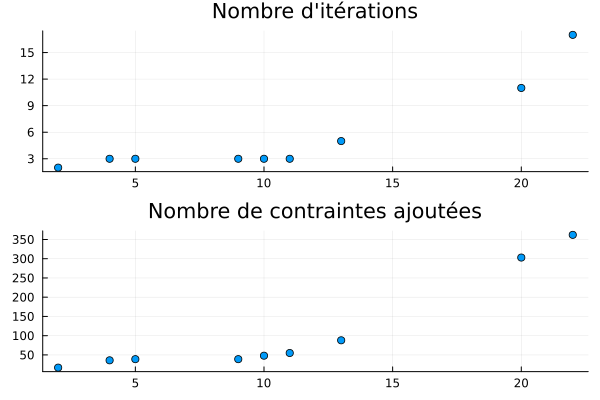

In [29]:
nb_cycles = []
nb_iterations = []
nb_added_constraints = []

# init the kep graph
kep_graph = read_kep_file("./_cache/data/MD-00001-00000001.wmd","./_cache/data/MD-00001-00000001.dat");
failure_rates = get_failure_rates(kep_graph, "Constant");

for i in 1:1:9
    data = extractCycleInformation(kep_graph, 3, "sum");
    C = data["Cycles_index"] 
    cycles = data["Cycles"]
    U = data["U"]
    ClusterSize = 10
    vertic_cycles = data["vertic_cycles"]
    nb_scenar = 100

    ksi = getScenarioClusterK(kep_graph, nb_scenar)

    res_lshape = LshapeClusterMethod(kep_graph, ClusterSize, C, cycles, U, vertic_cycles, ksi, 50, 1e-3, false)
    append!(nb_cycles, length(cycles))
    append!(nb_iterations, res_lshape["nb_iterations"])
    append!(nb_added_constraints, res_lshape["nb_added_constraints"])

    kep_graph = addRandomCycles(kep_graph, 1, 0.7, 1, 3)
end

p1 = Plots.scatter(nb_cycles, nb_iterations, title="Nombre d'itérations")
p2 = Plots.scatter(nb_cycles, nb_added_constraints, title="Nombre de contraintes ajoutées")
Plots.plot(p1, p2, layout=(2, 1), legend=false)

On peut voir une augmentation du nombre d'itérations ainsi que du nombre de contraintes rajoutées qui est de type exponentiel. Ainsi notre méthode de résolution va très surement rencontrer des problèmes lorsque nous allons traiter des instances conséquentes.

In [17]:
# init the kep graph
kep_graph = read_kep_file("./_cache/data/MD-00001-00000031.wmd","./_cache/data/MD-00001-00000031.dat");
failure_rates = get_failure_rates(kep_graph, "Constant");
data = extractCycleInformation(kep_graph, 2, "sum");
C = data["Cycles_index"] 
cycles = data["Cycles"]
U = data["U"]
ClusterSize = 5
vertic_cycles = data["vertic_cycles"]
nb_scenar = 20
ξ = getScenarioClusterK(kep_graph, nb_scenar)
res_lshape = LshapeClusterMethod(kep_graph, ClusterSize, C, cycles, U, vertic_cycles, ξ, 50, 1e-3, true)

### Modelisation averse au risque

$$
\begin{equation}
	\mathbb{RACP}:= \left\{\begin{aligned}
        \underset{x,t}{\min} &\quad t + \frac{1}{1-\alpha}\mathbb{E}_{\omega}\left[\left(\underset{y}{\min}\left( - \sum_{c \in C_K}y_c(\omega) w_c\right) - t\right)+\right]\\
         s.c &\quad x_{i,j} = x_{j,i}\quad \forall (i,j) \in V\times V\\
         &\quad x_{i,j} + x_{j,k} -1 \leq x_{i,k} \quad \forall (i,j,k) \in V\times V\times V\\
         &\quad \sum_{j \in V} x_{i,j} \leq U \quad \forall i \in V \\
         &\quad y_c(\omega) \leq x_{i,j}\xi_{i,j}(\omega) \quad \forall c \in C_k, ~\forall (i,j) \in c,~ \forall \omega \in \Omega \\
         &\quad \sum_{c \in C_K(i)} y_c(\omega) \leq 1 \quad \forall i \in V,\quad\forall \omega \in \Omega\\
	\end{aligned}\right.
\end{equation}
$$

Cette modélisation averse au risque peut, se linéariser de la façon suivante :

$$
\begin{equation}
	\mathbb{RACP}:= \left\{\begin{aligned}
        \underset{x,t}{\min} &\quad t + \frac{1}{(1-\alpha)\times |\Omega|}\sum_{\omega \in \Omega} \pi(\omega)\\
         s.c &\quad x_{i,j} = x_{j,i},\quad \forall (i,j) \in V\times V\\
         &\quad x_{i,j} + x_{j,k} -1 \leq x_{i,k}, \quad \forall (i,j,k) \in V\times V\times V\\
         &\quad \pi(\omega) \geq \left(\underset{y}{\min}\left( - \sum_{c\in C_K}y_c(\omega) w_c\right) - t\right),\quad \forall \omega \in \Omega \\
         &\quad \pi(\omega) \geq 0,\quad \forall \omega \in \Omega \\
         &\quad \sum_{j \in V} x_{i,j} \leq U, \quad \forall i \in V \\
         &\quad y_c(\omega) \leq x_{i,j}\xi_{i,j}(\omega) \quad \forall c \in C_k, ~\forall (i,j) \in c,~ \forall \omega \in \Omega \\
         &\quad \sum_{c \in C_K(i)} y_c(\omega) \leq 1 \quad \forall i \in V,\quad\forall \omega \in \Omega\\
         
	\end{aligned}\right.
\end{equation}
$$

On utilise une équation qui est bien connu est qui est que : $\min -f(x) = - \max f(x)$. Ainsi nous pouvons réecrire ce problème de la façon suivante :

$$
\begin{equation}
	\mathbb{RACP}:= \left\{\begin{aligned}
        \underset{x,t}{\min} &\quad t + \frac{1}{(1-\alpha)\times |\Omega|}\sum_{\omega \in \Omega} \pi(\omega)\\
         s.c &\quad x_{i,j} = x_{j,i},\quad \forall (i,j) \in V\times V\\
         &\quad x_{i,j} + x_{j,k} -1 \leq x_{i,k}, \quad \forall (i,j,k) \in V\times V\times V\\
         &\quad \sum_{j \in V} x_{i,j} \leq U, \quad \forall i \in V \\
         &\quad \pi(\omega) \geq \left(-v_{\omega}(x) - t\right),\quad \forall \omega \in \Omega \\
         &\quad \pi(\omega) \geq 0,\quad \forall \omega \in \Omega \\
	\end{aligned}\right.
\end{equation}
$$

Or nous avons exprimée la valeur du problème $v_{\omega}(x)$, dans la section précédente, ainsi nous pouvons réecrire ce problème de la facçon suivante :

$$
\begin{equation}
	\mathbb{RACP}:= \left\{\begin{aligned}
        \underset{x,t}{\min} &\quad t + \frac{1}{(1-\alpha)\times |\Omega|}\sum_{\omega \in \Omega} \pi(\omega)\\
         s.c &\quad x_{i,j} = x_{j,i},\quad \forall (i,j) \in V\times V\\
         &\quad x_{i,j} + x_{j,k} -1 \leq x_{i,k}, \quad \forall (i,j,k) \in V\times V\times V\\
         &\quad \sum_{j \in V} x_{i,j} \leq U, \quad \forall i \in V \\
         &\quad \pi(\omega) \geq \left(-\underset{\theta(\omega)}{\max}~~\theta(\omega) - t\right),\quad \forall \omega \in \Omega \\
         &\quad \theta(\omega) \leq \sum_{c \in C_{K}}\sum_{(i,j) \in c} \lambda_{(i,j)}^c x_{i,j}\xi_{i,j}(\omega) + \sum_{i \in V}\mu_i + \sum_{c \in C_K} \Delta_c \quad\forall~\lambda, \mu, \Delta ~\in~\Lambda(P), \forall \omega \in \Omega\\
         &\quad \pi(\omega) \geq 0,\quad \forall \omega \in \Omega \\
	\end{aligned}\right.
\end{equation}
$$

Nous pouvons finalement réecrire ce problème de la façon suivante :

$$
\begin{equation}
	\mathbb{RACP}:= \left\{\begin{aligned}
        \underset{x,t}{\min} &\quad t + \frac{1}{(1-\alpha)\times |\Omega|}\sum_{\omega \in \Omega} \pi(\omega)\\
         s.c &\quad x_{i,j} = x_{j,i},\quad \forall (i,j) \in V\times V\\
         &\quad x_{i,j} + x_{j,k} -1 \leq x_{i,k}, \quad \forall (i,j,k) \in V\times V\times V\\
         &\quad \sum_{j \in V} x_{i,j} \leq U, \quad \forall i \in V \\
         &\quad \pi(\omega) \geq \left(-\theta(\omega) - t\right),\quad \forall \omega \in \Omega \\
         &\quad \theta(\omega) \leq \sum_{c \in C_{K}}\sum_{(i,j) \in c} \lambda_{(i,j)}^c x_{i,j}\xi_{i,j}(\omega) + \sum_{i \in V}\mu_i + \sum_{c \in C_K} \Delta_c \quad\forall~\lambda, \mu, \Delta ~\in~\Lambda(P), \forall \omega \in \Omega\\
         &\quad \pi(\omega) \geq 0,\quad \forall \omega \in \Omega \\
	\end{aligned}\right.
\end{equation}
$$

En effet le maximum peut être retiré, il nous faut simplement un point réalisable.

Nous pouvons remarquer le gros avantage de cette méthode, est que elle nous permet pour un moindre coût d'implémentation, d'avoir une méthode concrète.



In [12]:
kep_graph = read_kep_file("./_cache/data/MD-00001-00000001.wmd","./_cache/data/MD-00001-00000001.dat");
failure_rates = get_failure_rates(kep_graph, "Constant");

data = extractCycleInformation(kep_graph, 3, "sum");
C = data["Cycles_index"] 
cycles = data["Cycles"]
U = data["U"]
ClusterSize = 5
vertic_cycles = data["vertic_cycles"]
nb_scenar = 1000

ksi = getScenarioClusterK(kep_graph, nb_scenar)

res_lshape = LshapeClusterMethod(kep_graph, ClusterSize, C, cycles, U, vertic_cycles, ksi, 50, 1e-3, false, true, 0.95)

Dict{String, Any} with 5 entries:
  "first_level_var"      => [1.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 …
  "objective_value"      => 0.0
  "nb_added_constraints" => 170
  "optimal"              => true
  "nb_iterations"        => 3